## Airbnb project

In [194]:
import pandas as pd
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import seaborn as sns
import numpy as np
import shapely
from shapely.ops import transform
from functools import partial
import pyproj
import geopy
from shapely import wkt
from geopy import distance
import folium

In [105]:
pd.options.mode.chained_assignment = None

In [106]:
hood = gpd.read_file('neighbourhoods.geojson')
metro = gpd.read_file('https://raw.githubusercontent.com/AlessandroTorella/Airbnb_project/main/metro.geojson')
trains = gpd.read_file('comboios.geojson')

# Metro dataset <a class="anchor" id="Introduction"></a>

In [107]:
df2 = metro.copy()
for i in range(len(df2)):
    if not '/' in df2['LINHA'][i]:
        df2.drop([i], axis=0, inplace=True)
df2 = df2.reset_index()

In [108]:
for i in range(len(metro)):
    if '/' in  metro['LINHA'][i]:
        metro['LINHA'][i] = metro['LINHA'][i].split('/')[0]

for j in range(len(df2)):
    df2['LINHA'][j] = df2['LINHA'][j].split('/')[1]
    
metro = pd.concat([metro, df2])

In [109]:
metro = pd.concat([metro, df2])

In [110]:
colors = {'Verde': 'green', 
          'Azul': 'blue', 
          'Azul/Verde': 'blue',
          'Amarela': 'red', 
          'Azul/Amarela': 'red',
          'Azul/Vermelha': 'blue',
          'Amarela/Vermelha': 'red',
          'Verde/Vermelha': 'green',
          'Amarela/Verde': 'red',
          'Vermelha': 'violet'
         }

In [111]:
metro['color_eng'] = (metro['LINHA']).map(colors)

In [112]:
yellow = metro[metro.LINHA == 'Amarela'].reset_index()
blue = metro[metro.LINHA == 'Azul'].reset_index()
green = metro[metro.LINHA == 'Verde'].reset_index()
red = metro[metro.LINHA == 'Vermelha'].reset_index()

# AIRBNB Dataset

In [114]:
df = pd.read_csv('listings.csv')
df = df.rename(columns = {'geometry': 'Coordinate'})
df = df.drop(columns = ['host_name', 'host_id', 'license', 'id', 'name'])

In [115]:
#df.isna().sum()

In [116]:
df = df.drop(columns = ['last_review', 'reviews_per_month'])

## One-hot encoding for room_type

Consider just the lisboa district

In [117]:
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.drop(columns = ['longitude', 'latitude'])
gdf = gdf.rename(columns = {'geometry': 'Coordinate'})
gdf_lisboa = gdf[gdf.neighbourhood_group == 'Lisboa']

Drop hotel category

In [118]:
gdf_lisboa = gdf[gdf.room_type != 'Hotel room']

Consider prices lower than 100 euros

In [119]:
gdf_lisboa = gdf_lisboa[gdf_lisboa['price'] < 100]

In [120]:
gdf_lisboa.describe()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,13417.000000,13417.000000,13417.000000,13417.000000,13417.000000,13417.000000
mean,57.445405,4.341880,54.705448,14.170157,216.790788,7.371022
std,21.247239,19.925313,80.619148,36.961717,130.830050,13.800556
min,8.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,42.000000,2.000000,4.000000,1.000000,99.000000,0.000000
50%,58.000000,2.000000,21.000000,4.000000,254.000000,3.000000
75%,74.000000,3.000000,74.000000,10.000000,340.000000,10.000000
max,99.000000,1000.000000,1550.000000,281.000000,365.000000,821.000000


## Prices per room type

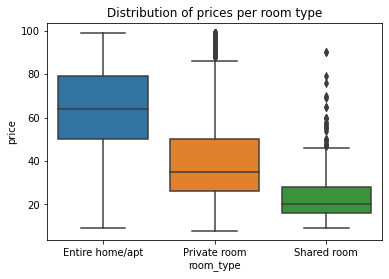

In [121]:
import seaborn as sns
#sns.displot(data = gdf_lisboa, x = 'price', kde=True).set(title = 'Price distribution');
sns.boxplot(data=gdf_lisboa, 
            y='price', 
            x='room_type').set(title='Distribution of prices per room type');

## Minimum nights distribution

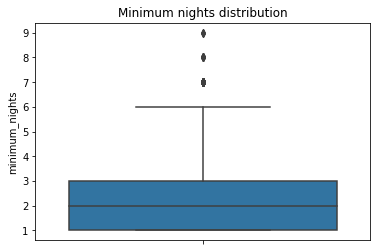

In [122]:
sns.boxplot(data = gdf_lisboa[gdf_lisboa['minimum_nights']<10], 
            y='minimum_nights').set(title = 'Minimum nights distribution');

It's safe to consider just 10 minimum nights

In [123]:
gdf_lisboa = gdf_lisboa[gdf_lisboa['minimum_nights'] < 10]

## Distribution of reviews per room_type

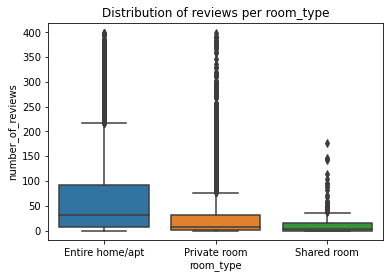

In [124]:
sns.boxplot(data = gdf_lisboa[gdf_lisboa['number_of_reviews']<400], 
            y ='number_of_reviews', 
            x='room_type',).set(title = 'Distribution of reviews per room_type');

In [125]:
gdf_lisboa = gdf_lisboa[gdf_lisboa['number_of_reviews'] < 400]

In [126]:
gdf_lisboa = gdf_lisboa.reset_index()

# Distance function applied to rate Airbnb listings

In [127]:
def distance_from(longlat_tuple,df,name_of_place):
    
    col_name = 'Distance from ' + str(name_of_place)
    
    from_place_list = []
    location = Point(longlat_tuple)
    project = partial(pyproj.transform, pyproj.Proj('EPSG:4326'), pyproj.Proj('EPSG:32633'))
    for i in df.Coordinate:
        line_string = shapely.geometry.LineString([i,location])
        trans = transform(project, line_string)
        from_place_list.append(int(trans.length))

    df[col_name] = from_place_list

In [128]:
list_of_monuments = {'Mosteiro dos Jerónimos': (-9.204487, 38.697819),
                    'Oceanário de Lisboa': (-9.0937, 38.7635),
                    'Museu Nacional de Arte Antiga': (-9.141161, 38.708460),
                    'Torre de Belem': (-9.2147, 38.6967),
                    'Elevador de Santa Justa': (-9.139221, 38.712173),
                    'Padrão dos Descobrimentos': (-9.205712, 38.693596),
                    'Praça do Comércio': (-9.136744, 38.707779),
                    'Museu de Arte, Arquitectura e Tecnologia': (-9.194453, 38.695927),
                    }

# Read the weight file

In [129]:
weight = pd.read_excel('weight.xlsx')
weight = weight.drop(columns=['Unnamed: 0'])
weight['Coordinate'] = weight['Coordinate'].apply(wkt.loads) #changes Coordinate from String to Shapely object type. 

### Distance function between two points

In [130]:
def distance_p1p2(p1, p2):
    return distance.distance((p1.y,p1.x), (p2.y,p2.x)).km

### Distance between each station and Airbnnb

In [181]:
distance_from(Point(-9.204487, 38.697819), gdf_lisboa, 'Mosteiro dos Jerónimos')

In [183]:
gdf_lisboa.head()

,index,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,Coordinate,Distance from 49,Distance from Mosteiro dos Jerónimos
0,0,Lisboa,Belm,Entire home/apt,40,3,32,1,315,6,POINT (-9.19768 38.69750),821,821
1,1,Lisboa,Santa Maria Maior,Entire home/apt,50,2,127,1,325,14,POINT (-9.12706 38.71241),9494,9494
2,2,Lisboa,Santa Maria Maior,Entire home/apt,60,5,337,1,190,13,POINT (-9.12719 38.71082),9445,9445
3,3,Lisboa,Santa Maria Maior,Entire home/apt,60,2,299,1,302,40,POINT (-9.12987 38.71156),9142,9142
4,5,Lisboa,Avenidas Novas,Entire home/apt,50,5,46,1,228,8,POINT (-9.15264 38.74571),8483,8483


In [184]:
near_mosteiro = gdf_lisboa[gdf_lisboa['Distance from Mosteiro dos Jerónimos'] < 1000]

In [213]:
round(near_mosteiro.price.mean(),2)

59.79

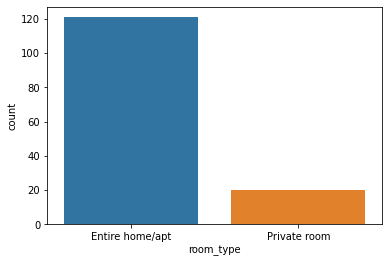

In [222]:
sns.countplot(x = 'room_type', data = near_mosteiro);

In [223]:
lisbon_coordinates = Point(-9.15005, 38.72532)
m = folium.Map(location = [lisbon_coordinates.y, lisbon_coordinates.x], zoom_start=15)

for i, v in near_mosteiro.iterrows():
    folium.Marker(location=[v.Coordinate.y, v.Coordinate.x],
                  popup = str(v.price)+'€',
                  radius = 1.2,
                  color = '#00C4B3',
                  fill_color = '#00C4B3',
                  fill=True).add_to(m)

In [224]:
m